<a href="https://colab.research.google.com/github/Dezyderata/NAI_lab2/blob/master/Copy_of_lab2_nai_szablon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorium 2: NAI - Implementacja sieci neuronowej
---

***Autor laboratorium: Katarzyna Dziopa***

Cel: zbudowanie sieci neuronowej z wykorzystaniem biblioteki NumPy w Pythonie.

Student: Agnieszka Rydzyk

## Importowanie bibliotek

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
import math
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from IPython.display import Image

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score


sns.set_style("whitegrid")

## Stworzenie zbioru wejściowego

In [114]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

X, y = sklearn.datasets.make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
# Podzial danych wejsciowych na dane testowe i dane treningowe.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Rozmiar danych wejściowych
print(X.shape)

# Rozmiar danych wyjściowych
print(y.shape)


(1000, 2)
(1000,)


In [0]:
# Funkcja do wizualizacji danych wejściowych
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

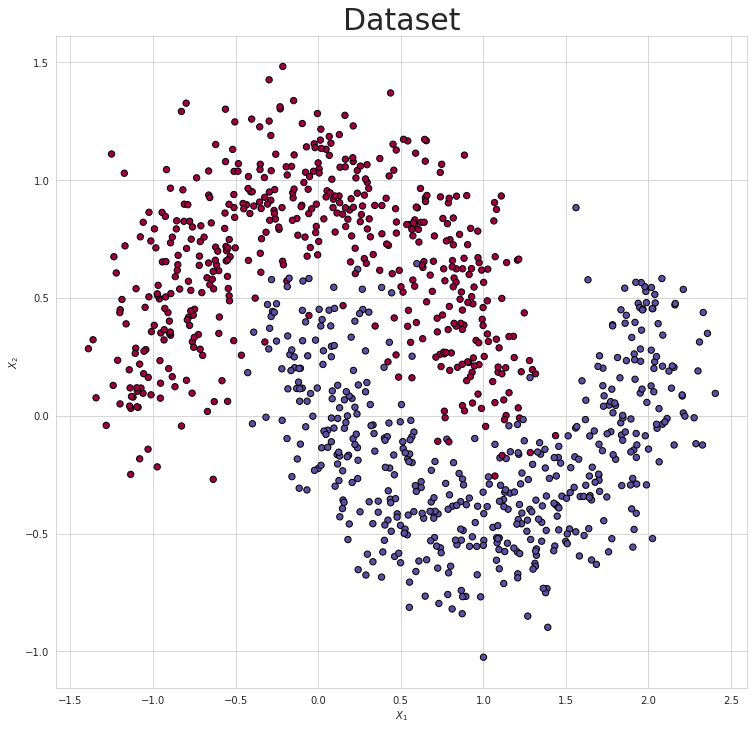

In [116]:
# Wizualizacja danych wejściowych

make_plot(X, y, "Dataset")

## Definicja warstw sieci neuronowej

In [0]:
# input_dim - rozmiar sygnału wejściowego
# output_dim - rozmiar wektora aktywacji na wyjściu z warstwy
# activation - funkcja aktywacji
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

## Inicjacja parametrów wejściowych dla każdej z warstw

In [0]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1

        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # Zad 1: Zdefiniuj wartości wejściowe macierzy W i wektora b dla kolejnych warstw
        # sieci neuronowej. Wartości wag powinny być stosunkowo małe.
        # Wskazówka: wykorzystaj funkcję `np.random.randn` pomnożoną przez współczynnik 0.1 - 2 ptk
        params_values["W" + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size)*0.1
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1)*0.1
        
        
        
        # Sprawdzenie wymiarów
        assert(params_values['W' + str(layer_idx)].shape == (layer_output_size, layer_input_size))
        assert(params_values['b' + str(layer_idx)].shape == (layer_output_size, 1))

        
        
    return params_values

In [119]:
params_values = init_layers(NN_ARCHITECTURE)
print(params_values)

{'W1': array([[-0.01423588,  0.20572217],
       [ 0.02832619,  0.1329812 ],
       [-0.01546219, -0.00690309],
       [ 0.07551805,  0.08256466],
       [-0.01130692, -0.23678376],
       [-0.01670494,  0.0685398 ],
       [ 0.00235001,  0.04562013],
       [ 0.02704928, -0.14350081],
       [ 0.08828171, -0.05800817],
       [-0.05015653,  0.05909533],
       [-0.07316163,  0.02617555],
       [-0.08557956, -0.01875259],
       [-0.03734863, -0.0461971 ],
       [-0.08164661, -0.00451233],
       [ 0.01213278,  0.09259528],
       [-0.05738197,  0.00527031],
       [ 0.22073106,  0.03918219],
       [ 0.04827134,  0.0433334 ],
       [-0.17042917, -0.02439081],
       [-0.21397038,  0.08613227],
       [ 0.17002844, -0.05287848],
       [ 0.17634779, -0.11216078],
       [-0.11919342,  0.05527319],
       [-0.08159809, -0.04966468],
       [ 0.10862256, -0.09746753]]), 'b1': array([[-0.02821358],
       [-0.01172141],
       [ 0.03785473],
       [ 0.07321946],
       [-0.0103571 ],


## Funkcja aktywacji

In [0]:
def sigmoid(Z):
    # Zad 2/ czesc 1: Zaimplementuj funcje sigmoid - 1ptk
    return 1/(1+math.e**(-Z))

def relu(Z):
    # Zad 2/ czesc 2: Zaimplementuj funkcje relu - 1 ptk
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [121]:
print(sigmoid(3))
print(relu(2))

0.9525741268224331
2


## Propagacja wprzód (forward propagation) dla pojedynczej warstwy

Dla danego sygnału z poprzedniej warstwy będziemy obliczać transformację Z i aplikować funkcję aktywacji. W celu przyspieszenia obliczeń wykorzystamy operacje macierzowe, żeby obliczyć przekształcenie dla całej warstwy.

* l - indeks warstwy
* g - funkcja aktywacji
* A - wektor aktywcji

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [0]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # activation - funkcja aktywacji
  
    # Zad 3: Zaimplementuj funckcje propagacji w przod dla jednej warstwy sieci neuronowej
    # Wskazowka: mozna wykorzystac operacje `dot` z biblioteki NumPy - 2 ptk
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    
    if activation == "relu":
      A_curr = relu(Z_curr)
    elif activation == "sigmoid":
      A_curr = sigmoid(Z_curr)
    else:
      raise Exception("Brak takiej funkcji aktywacji")
    
    assert(Z_curr.shape[0] == W_curr.shape[0])
    
    return A_curr, Z_curr

In [123]:
single_layer_forward_propagation(0,params_values["W"+str(1)],params_values["b"+str(1)])

(array([[0.        , 0.        ],
        [0.        , 0.        ],
        [0.03785473, 0.03785473],
        [0.07321946, 0.07321946],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.10100356, 0.10100356],
        [0.28753603, 0.28753603],
        [0.08203126, 0.08203126],
        [0.05606115, 0.05606115],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.06173323, 0.06173323],
        [0.        , 0.        ],
        [0.1287905 , 0.1287905 ],
        [0.        , 0.        ],
        [0.13643321, 0.13643321],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.0639322 , 0.0639322 ],
        [0.0774304 , 0.0774304 ]]), array([[-0.02821358, -0.02821358],
        [-0.01172141, -0.01172141],
        [ 0.03785473,  0.03785473],
        [ 0.07321946,  0.07321946],
     

In [124]:
single_layer_forward_propagation(0,params_values["W"+str(1)],params_values["b"+str(1)], "sigmoid")

(array([[0.49294707, 0.49294707],
        [0.49706968, 0.49706968],
        [0.50946255, 0.50946255],
        [0.51829669, 0.51829669],
        [0.49741075, 0.49741075],
        [0.47006818, 0.47006818],
        [0.52522944, 0.52522944],
        [0.57139281, 0.57139281],
        [0.52049632, 0.52049632],
        [0.51401162, 0.51401162],
        [0.49061005, 0.49061005],
        [0.49369773, 0.49369773],
        [0.46531546, 0.46531546],
        [0.51542841, 0.51542841],
        [0.49660538, 0.49660538],
        [0.53215319, 0.53215319],
        [0.47409835, 0.47409835],
        [0.53405549, 0.53405549],
        [0.4922517 , 0.4922517 ],
        [0.48472683, 0.48472683],
        [0.4879247 , 0.4879247 ],
        [0.48478011, 0.48478011],
        [0.44798053, 0.44798053],
        [0.51597761, 0.51597761],
        [0.51934793, 0.51934793]]), array([[-0.02821358, -0.02821358],
        [-0.01172141, -0.01172141],
        [ 0.03785473,  0.03785473],
        [ 0.07321946,  0.07321946],
     

## Propagacja wprzód dla wszystkich warstw

W obliczeniach wykorzystamy zaimplementowaną wcześniej funkcję: `single_layer_forward_propagation` do obliczenia propagacji wprzód dla wszystkich warstw.

In [0]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # Zadanie 4: Oblicz macierz aktywacji (A_curr) i wektor transformacji (Z_curr)
        # z wykorzystaniem wcześniej zaimplementowanej funkcji: `single_layer_forward_propagation`
        activation_l = layer["activation"]
        W_curr = params_values["W"+str(layer_idx)]
        b_curr = params_values["b"+str(layer_idx)]
        
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activation_l)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In [126]:
a_curr, memo = full_forward_propagation(0,params_values,NN_ARCHITECTURE)
print(a_curr)

[[0.51928622 0.51928622]]


In [127]:
print(memo)

{'A0': 0, 'Z1': array([[-0.02821358, -0.02821358],
       [-0.01172141, -0.01172141],
       [ 0.03785473,  0.03785473],
       [ 0.07321946,  0.07321946],
       [-0.0103571 , -0.0103571 ],
       [-0.11987063, -0.11987063],
       [ 0.10100356,  0.10100356],
       [ 0.28753603,  0.28753603],
       [ 0.08203126,  0.08203126],
       [ 0.05606115,  0.05606115],
       [-0.03756422, -0.03756422],
       [-0.02521043, -0.02521043],
       [-0.13896134, -0.13896134],
       [ 0.06173323,  0.06173323],
       [-0.0135787 , -0.0135787 ],
       [ 0.1287905 ,  0.1287905 ],
       [-0.10369944, -0.10369944],
       [ 0.13643321,  0.13643321],
       [-0.03099566, -0.03099566],
       [-0.06111171, -0.06111171],
       [-0.04831058, -0.04831058],
       [-0.06089837, -0.06089837],
       [-0.20883353, -0.20883353],
       [ 0.0639322 ,  0.0639322 ],
       [ 0.0774304 ,  0.0774304 ]]), 'A1': array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.03785473, 0.03785473],
  

## Obliczanie funkcji kosztu

In [0]:
def get_cost_value(Y_hat, Y):
     # Liczba przykładów
    m = Y_hat.shape[1]
    
    # Zad 5: Zaimplementuj funkcje kosztu,(binary cross-entropy) zgodnie z 
    # definicją podaną w laboratorium. Wykorzystaj operację `np.dot` do
    # mnożenia macierzy. 
    # Wskazówka: przed wykonaniem mnożenia na macierzach, wykonaj operację
    # transpozycji na macierzy (`numpy.ndarray.T.`) - 2 ptk
    # cost = - (1 / m) * np.sum(np.multiply(Y, np.log(Y_hat)) + np.multiply(1 - Y, np.log(1 - Y_hat)))
    cost = -1/m*(np.dot(Y, np.log(Y_hat).T) + np.dot(1-Y, np.log(1-Y_hat).T))
    # `np.squeeze` - removes single-dimensional entries from the shape of an array
    return np.squeeze(cost)

In [0]:
def get_cost_value2(Y_hat, Y):
     # Liczba przykładów
    m = Y_hat.shape[1]
    
    # Zad 5: Zaimplementuj funkcje kosztu,(binary cross-entropy) zgodnie z 
    # definicją podaną w laboratorium. Wykorzystaj operację `np.dot` do
    # mnożenia macierzy. 
    # Wskazówka: przed wykonaniem mnożenia na macierzach, wykonaj operację
    # transpozycji na macierzy (`numpy.ndarray.T.`) - 2 ptk
    cost = - (1 / m) * np.sum(np.multiply(Y, np.log(Y_hat)) + np.multiply(1 - Y, np.log(1 - Y_hat)))
    # cost = -1/m*(np.dot(Y, np.log(Y_hat).T) + np.dot(1-Y, np.log(1-Y_hat).T))
    # `np.squeeze` - removes single-dimensional entries from the shape of an array
    return np.squeeze(cost)

## Obliczanie dokładności

In [0]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [0]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

## Propagacja wsteczna dla pojedynczej warstwy

Propagacja wsteczna jest to podstawowy algorytm uczenia nadzorowanego wielowarstwowych, jednokierunkowych sieci neuronowych. Podaje on przepis na zmianę wag dowolnych połączeń elementów przetwarzających rozmieszczonych w sąsiednich warstwach sieci. Oparty jest on na minimalizacji funkcji błędu uczenia z wykorzystaniem optymalizacyjnej metody największego spadku. 

Uwaga: zagadnienie te nie będzie szczegółowo omawiane na zajęciach.

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



In [0]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

## Propagacja wsteczna dla wszystkich warstw


$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [0]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Uaktualnanie wartości parametrów

In [0]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

## Definicja metody trenowania

In [0]:
# X - zbiór wejściowy
# Y - zbiór wyjściowy
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=True):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            
    return params_values, cost_history, accuracy_history

### Let's put our model to the test

In [136]:
# Proces trenowania
params_values, my_cost, my_accuracy = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 3500, 0.01)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

In [0]:
# Proces predykcji
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [138]:
# Dokładność uzyskana na zbiorze testowym
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Dokładność na zbiorze testowym: {:.2f}".format(acc_test))

Dokładność na zbiorze testowym: 0.83


In [0]:
# Zadanie 6*: Napisz funkcję wizualizującą funkcję kosztu oraz dokładność w zależności od numeru iteracji. 
# Wizualizacja nie musi generować się w trakcie procesu uczenia. - 2 ptk

In [0]:
import pandas as pd

def accuracy_and_cost(my_accuracy, my_cost):
    x = len(my_accuracy)//50
    x_pos = [x*50 for x in range(x)]
    my_acc = my_accuracy[::50]
    my_cos =list(map(float, my_cost[::50]))
    df = pd.DataFrame({'accuracy':my_acc, 'cost':my_cos}, index=x_pos)

    # ax = df.plot.bar(rot=0)
    # ax.set_xlabel("iterations")
    ax =df.plot(figsize=(10,5))
    ax.set_xlabel("iterations")




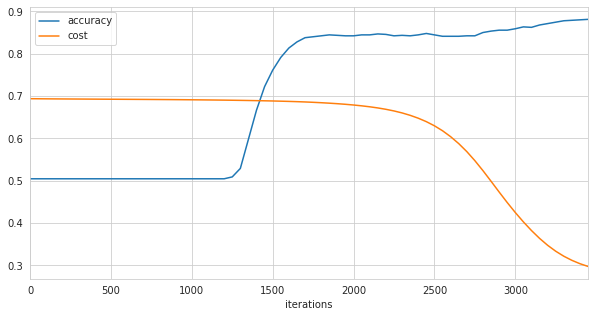

In [141]:
accuracy_and_cost(my_accuracy, my_cost)

Testing different values of learning_rate

In [142]:
params_values2, my_cost2, my_accuracy2 = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 2500, 0.02)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69142 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69109 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69070 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69025 - accuracy: 0.50444
Iteration: 00650 - cost: 0.68972 - accuracy: 0.52889
Iteration: 00700 - cost: 0.68907 - accuracy: 0.66556
Iteration: 00750 - cost: 0.68827 - accuracy: 0.76000
Iteration: 00800 - cost: 0.68727 - accuracy: 0.81333
Iteration: 00850 - cost: 0.68598 - accuracy: 0.83778
Iteration: 00900 - cost: 0.68418 - accuracy: 0

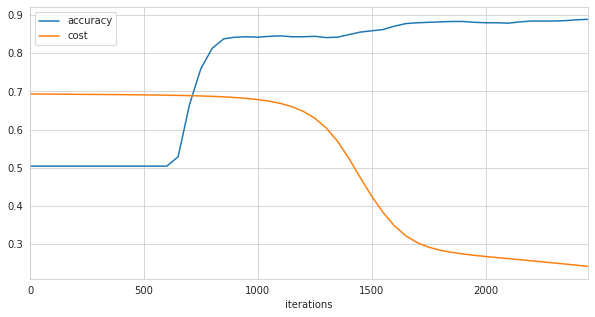

In [143]:
accuracy_and_cost(my_accuracy2, my_cost2)

In [144]:
params_values3, my_cost3, my_accuracy3 = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 1500, 0.1)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69239 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69110 - accuracy: 0.50444
Iteration: 00150 - cost: 0.68833 - accuracy: 0.75556
Iteration: 00200 - cost: 0.67914 - accuracy: 0.84444
Iteration: 00250 - cost: 0.63291 - accuracy: 0.84333
Iteration: 00300 - cost: 0.43342 - accuracy: 0.85778
Iteration: 00350 - cost: 0.29379 - accuracy: 0.88111
Iteration: 00400 - cost: 0.26838 - accuracy: 0.88000
Iteration: 00450 - cost: 0.25429 - accuracy: 0.88444
Iteration: 00500 - cost: 0.23909 - accuracy: 0.89000
Iteration: 00550 - cost: 0.21588 - accuracy: 0.90111
Iteration: 00600 - cost: 0.17539 - accuracy: 0.93000
Iteration: 00650 - cost: 0.12952 - accuracy: 0.94889
Iteration: 00700 - cost: 0.10634 - accuracy: 0.95889
Iteration: 00750 - cost: 0.09812 - accuracy: 0.96444
Iteration: 00800 - cost: 0.09462 - accuracy: 0.96667
Iteration: 00850 - cost: 0.09268 - accuracy: 0.96667
Iteration: 00900 - cost: 0.09084 - accuracy: 0

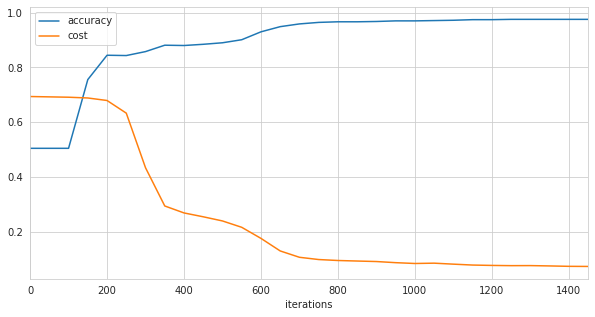

In [145]:
accuracy_and_cost(my_accuracy3, my_cost3)

In [146]:
params_values4, my_cost4, my_accuracy4 = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 3000, 0.01)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

In [147]:
params_values5, my_cost5, my_accuracy5 = train2(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 3000, 0.01)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

In [0]:
def train2(X, Y, nn_architecture, epochs, learning_rate, verbose=True):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value2(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            
    return params_values, cost_history, accuracy_history

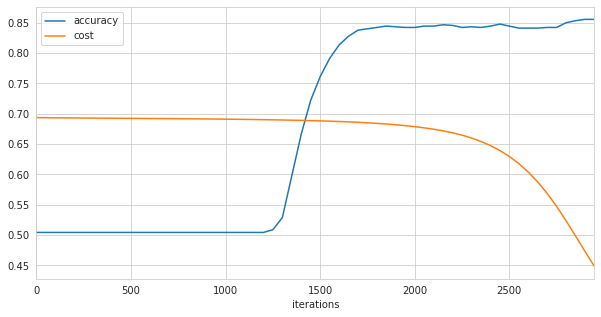

In [149]:
accuracy_and_cost(my_accuracy4, my_cost4)

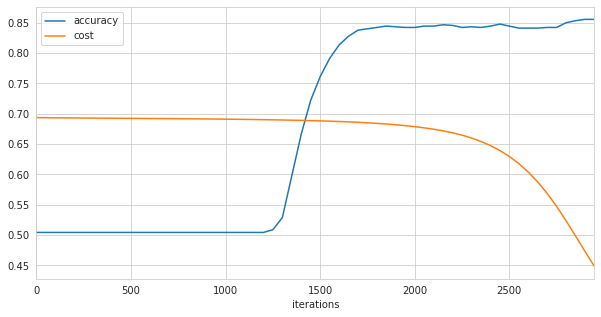

In [150]:
accuracy_and_cost(my_accuracy5, my_cost5)

Different architecture

In [0]:
NN_ARCHITECTURE2 = [
    {"input_dim": 2, "output_dim": 25, "activation": "sigmoid"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

In [152]:
params_values_a2, my_cost_a2, my_accuracy_a2 = train2(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE2, 3000, 0.03)

Iteration: 00000 - cost: 0.69437 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69283 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69266 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69255 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69247 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69240 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69232 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69224 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69216 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69196 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69180 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69159 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69143 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69126 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69107 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69085 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69060 - accuracy: 0

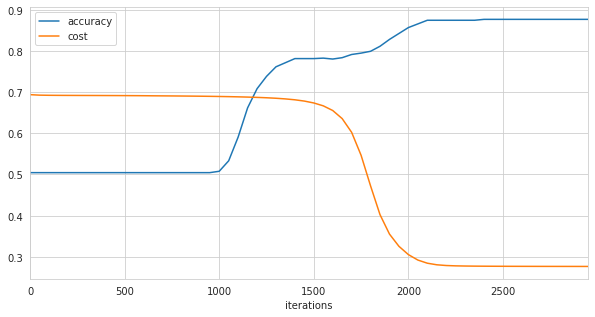

In [153]:
accuracy_and_cost(my_accuracy_a2, my_cost_a2)

In [0]:
NN_ARCHITECTURE3 = [
    {"input_dim": 2, "output_dim": 25, "activation": "sigmoid"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 100, "activation": "relu"},
    {"input_dim": 100, "output_dim": 100, "activation": "relu"},
    {"input_dim": 100, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]


In [155]:
params_values_a3, my_cost_a3, my_accuracy_a3 = train2(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE3, 3000, 0.03)

Iteration: 00000 - cost: 0.69361 - accuracy: 0.49556
Iteration: 00050 - cost: 0.69322 - accuracy: 0.49556
Iteration: 00100 - cost: 0.69309 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69302 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69297 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69293 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69289 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69286 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69283 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69280 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69276 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69273 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69269 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69265 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69256 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69251 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69245 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69239 - accuracy: 0

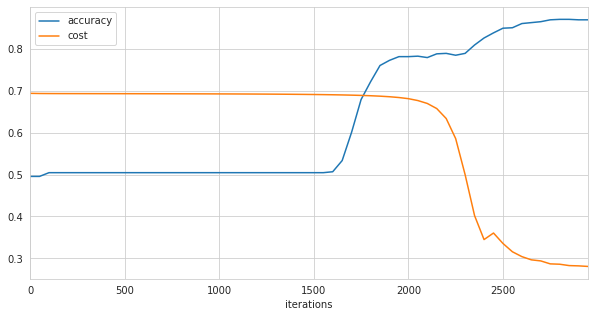

In [156]:
accuracy_and_cost(my_accuracy_a3, my_cost_a3)